In [ ]:
# @title
import os

# Set Kaggle username and API token
os.environ["KAGGLE_USERNAME"] = "sairamreddykorimilla"
os.environ["KAGGLE_KEY"] = "sairam_token"#Kaggle Token


In [ ]:
# @title
#libraried installation and data downloads
!kaggle competitions download -c ieee-fraud-detection
!unzip ieee-fraud-detection.zip -d /content/dataset-folder
#!pip install polars -#Already installed for Colab

 99% 117M/118M [00:06<00:00, 22.6MB/s]
100% 118M/118M [00:06<00:00, 17.8MB/s]
Archive:  ieee-fraud-detection.zip
  inflating: /content/dataset-folder/sample_submission.csv  
  inflating: /content/dataset-folder/test_identity.csv  
  inflating: /content/dataset-folder/test_transaction.csv  
  inflating: /content/dataset-folder/train_identity.csv  
  inflating: /content/dataset-folder/train_transaction.csv  


Training fold 1/5
[0]	eval-auc:0.81724
[100]	eval-auc:0.88154
[200]	eval-auc:0.89344
[300]	eval-auc:0.89887
[400]	eval-auc:0.90116
[500]	eval-auc:0.90188
[597]	eval-auc:0.90184
Training fold 2/5
[0]	eval-auc:0.82305
[100]	eval-auc:0.90310
[200]	eval-auc:0.91765
[300]	eval-auc:0.92144
[400]	eval-auc:0.92403
[500]	eval-auc:0.92552
[600]	eval-auc:0.92640
[700]	eval-auc:0.92649
[800]	eval-auc:0.92657
[900]	eval-auc:0.92638
[939]	eval-auc:0.92627
Training fold 3/5
[0]	eval-auc:0.83526
[100]	eval-auc:0.90469
[200]	eval-auc:0.91862
[300]	eval-auc:0.92241
[400]	eval-auc:0.92409
[500]	eval-auc:0.92485
[600]	eval-auc:0.92504
[700]	eval-auc:0.92483
[761]	eval-auc:0.92471
Training fold 4/5
[0]	eval-auc:0.83021
[100]	eval-auc:0.89484
[200]	eval-auc:0.91188
[300]	eval-auc:0.91802
[400]	eval-auc:0.92068
[500]	eval-auc:0.92269
[600]	eval-auc:0.92463
[700]	eval-auc:0.92540
[800]	eval-auc:0.92610
[900]	eval-auc:0.92675
[999]	eval-auc:0.92725
Training fold 5/5
[0]	eval-auc:0.81866
[100]	eval-auc:0.89620


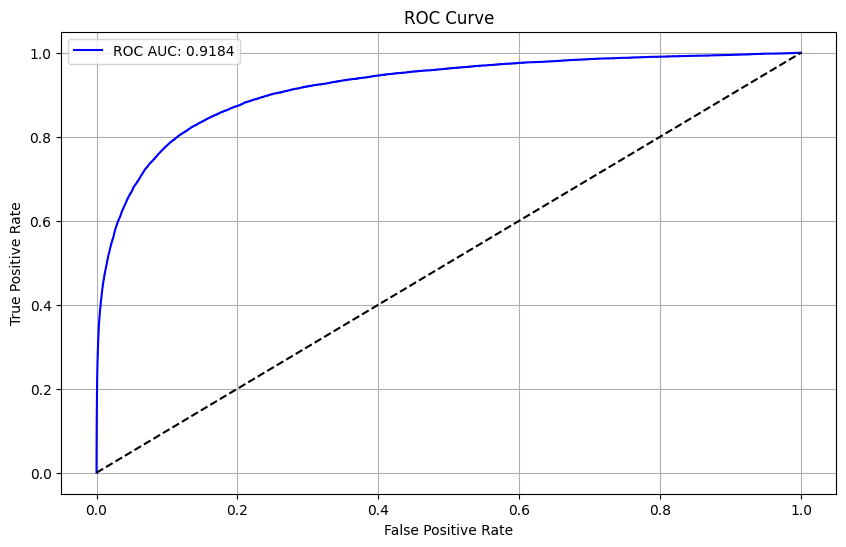

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, roc_curve
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

# Define data types for efficient memory usage
data_types = {
    **{'TransactionID': 'int32', 'TransactionDT': 'int32', 'TransactionAmt': 'float32'},
    **{f'V{i}': 'float32' for i in range(1, 340)},
    **{f'C{i}': 'float32' for i in range(1, 15)},
    **{f'D{i}': 'float32' for i in range(1, 16)},
    **{f'M{i}': 'object' for i in range(1, 10)},
    'ProductCD': 'object', 'card1': 'int32', 'card2': 'float32', 'card3': 'float32',
    'card4': 'object', 'card5': 'float32', 'card6': 'object', 'addr1': 'float32', 'addr2': 'float32',
    'P_emaildomain': 'object', 'R_emaildomain': 'object'
}

class FraudDetectionModel:
    def __init__(self, use_gpu=True):
        self.use_gpu = use_gpu
        self.features = None
        self.model = None
        self.train_data = None
        self.test_data = None
        self.target = None
        self.oof_predictions = None
        self.test_predictions = None

        # XGBoost parameters
        self.xgb_params = {
            'n_estimators': 1500,
            'max_depth': 8,
            'learning_rate': 0.025,
            'subsample': 0.85,
            'colsample_bytree': 0.7,
            'colsample_bylevel': 0.7,
            'colsample_bynode': 0.7,
            'min_child_weight': 3,
            'reg_alpha': 0.05,
            'reg_lambda': 0.8,
            'scale_pos_weight': 27.5,
            'missing': -1,
            'eval_metric': 'auc',
            'early_stopping_rounds': 100,
            'tree_method': 'gpu_hist' if self.use_gpu else 'hist',
            'device': 'cuda' if self.use_gpu else 'cpu'
        }

    def load_dataset(self, transaction_train, identity_train, transaction_test, identity_test):
        """Load and merge transaction and identity datasets"""
        self.train_data = pd.read_csv(transaction_train, dtype=data_types).set_index('TransactionID')
        train_identity = pd.read_csv(identity_train, dtype=data_types).set_index('TransactionID')
        self.test_data = pd.read_csv(transaction_test, dtype=data_types).set_index('TransactionID')
        test_identity = pd.read_csv(identity_test, dtype=data_types).set_index('TransactionID')

        self.train_data = self.train_data.merge(train_identity, how='left', left_index=True, right_index=True)
        self.test_data = self.test_data.merge(test_identity, how='left', left_index=True, right_index=True)
        self.test_data.rename(columns=lambda col: col.replace('-', '_'), inplace=True)

        self.target = self.train_data.pop('isFraud')
        gc.collect()

    def apply_frequency_encoding(self, columns):
        """Perform frequency encoding on specified columns"""
        for col in columns:
            combined_data = pd.concat([self.train_data[col], self.test_data[col]])
            value_counts = combined_data.value_counts(normalize=True).to_dict()
            self.train_data[f'{col}_FE'] = self.train_data[col].map(value_counts).astype('float32')
            self.test_data[f'{col}_FE'] = self.test_data[col].map(value_counts).astype('float32')

    def apply_label_encoding(self):
        """Perform label encoding on categorical features"""
        for col in self.train_data.select_dtypes(include=['object']).columns:
            combined_encoded = pd.concat([self.train_data[col], self.test_data[col]], axis=0).factorize(sort=True)[0]
            dtype = 'int32' if combined_encoded.max() > 32000 else 'int16'
            self.train_data[col] = combined_encoded[:len(self.train_data)].astype(dtype)
            self.test_data[col] = combined_encoded[len(self.train_data):].astype(dtype)
            gc.collect()

    def generate_features(self):
        """Prepare feature set including time-based features and encodings"""
        self.train_data['Month'] = (self.train_data['TransactionDT'] // (30 * 24 * 60 * 60)).astype(int)
        self.test_data['Month'] = (self.test_data['TransactionDT'] // (30 * 24 * 60 * 60)).astype(int)

        self.apply_label_encoding()
        self.apply_frequency_encoding(['addr1', 'card1', 'card2', 'card3', 'P_emaildomain'])

        self.features = [col for col in self.train_data.columns if col != 'TransactionDT']

    def train_xgboost_model(self, n_splits=5):
        """Train the XGBoost model using GroupKFold cross-validation"""
        self.oof_predictions = np.zeros(len(self.train_data))
        self.test_predictions = np.zeros(len(self.test_data))
        group_kfold = GroupKFold(n_splits=n_splits)

        for fold, (train_idx, val_idx) in enumerate(group_kfold.split(self.train_data, self.target, self.train_data['Month'])):
            print(f'Training fold {fold+1}/{n_splits}')

            train_set = xgb.DMatrix(self.train_data.iloc[train_idx][self.features], label=self.target.iloc[train_idx])
            validation_set = xgb.DMatrix(self.train_data.iloc[val_idx][self.features], label=self.target.iloc[val_idx])
            test_set = xgb.DMatrix(self.test_data[self.features])

            self.model = xgb.train(self.xgb_params, train_set, num_boost_round=1000,
                                   evals=[(validation_set, 'eval')], early_stopping_rounds=100, verbose_eval=100)

            self.oof_predictions[val_idx] = self.model.predict(validation_set)
            self.test_predictions += self.model.predict(test_set) / n_splits
            gc.collect()

        print(f'Cross-Validation ROC AUC: {roc_auc_score(self.target, self.oof_predictions):.4f}')
        self.plot_roc_curve(self.target, self.oof_predictions, self.test_predictions)

    def plot_roc_curve(self, actual, train_predictions, test_predictions):
        """Plot the ROC curve"""
        plt.figure(figsize=(10, 6))

        fpr, tpr, _ = roc_curve(actual, train_predictions)
        plt.plot(fpr, tpr, label=f'ROC AUC: {roc_auc_score(actual, train_predictions):.4f}', color='blue')

        plt.plot([0, 1], [0, 1], linestyle='--', color='black')

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.grid()
        plt.show()


if __name__ == "__main__":
    fraud_model = FraudDetectionModel(use_gpu=True)
    fraud_model.load_dataset('/content/dataset-folder/train_transaction.csv',
                             '/content/dataset-folder/train_identity.csv',
                             '/content/dataset-folder/test_transaction.csv',
                             '/content/dataset-folder/test_identity.csv')
    fraud_model.generate_features()
    fraud_model.train_xgboost_model(n_splits=5)
